### Test the trained network

In [108]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 2
d = 3


- Network to load

In [110]:
timestamp = "2018-07-28_14:39"

epoch = 200

- Load gmm params

In [111]:
import numpy as np

In [112]:
filename=timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [113]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [114]:
K.eval(phi)

array([0.4994552 , 0.50054485], dtype=float32)

In [115]:
K.eval(mu)

array([[1.410799 , 1.410799 , 1.410799 ],
       [1.4095881, 1.4095881, 1.4095881]], dtype=float32)

In [116]:
K.eval(sigma)

array([[[2.0660095 , 1.004974  , 0.98583096],
        [1.004974  , 0.4976533 , 0.47199622],
        [0.98583096, 0.47199622, 0.4769822 ]],

       [[2.063212  , 1.0108837 , 0.97651047],
        [1.0108837 , 0.5045837 , 0.47049367],
        [0.97651047, 0.47049367, 0.469099  ]]], dtype=float32)

- Plot loss history

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt

In [118]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [119]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_title("Loss graph for end-to-end training")

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [120]:
filename = timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

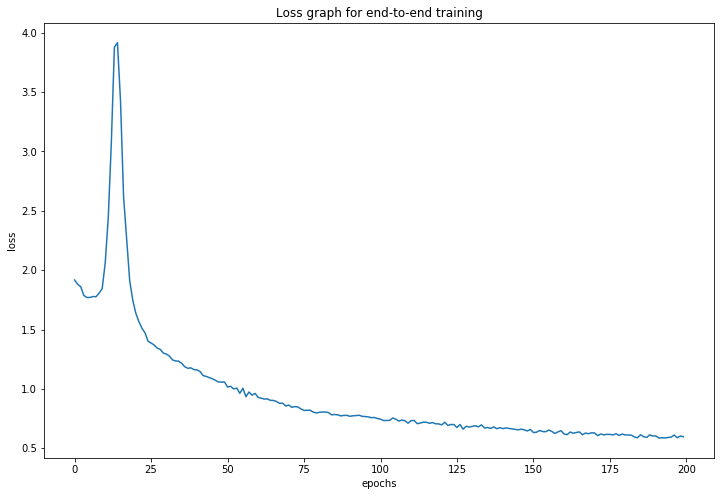

In [121]:
plotHistory(history, save=True)

- Network definition for testing

In [123]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,21), name='input_placeholder')

encoded = Dense(18, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(12, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(4, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
# encoded = Dense(1, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(4, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(12, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(18, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(21, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
# decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)





### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 21)              0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (1, 18)              396         input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_25 (Dense)                (1, 12)              228         dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (1, 4)               52          dense_25[0][0]                   
__________________________________________________________________________________________________
lowdim (De

/Users/jyotirmaysenapati/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [124]:
filename = timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [125]:
import numpy as np

In [126]:
with np.load('thyroid_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']
#     x_test = x_test[:, 0:6]

print(x_test)
# print(y_test)

[[0.66666667 1.         0.         ... 0.26516573 0.         1.        ]
 [0.52083333 0.         0.         ... 0.17748593 0.         1.        ]
 [0.54166667 0.         0.         ... 0.1713571  0.         1.        ]
 ...
 [0.29166667 0.         0.         ... 0.12914321 0.         1.        ]
 [0.57291667 1.         0.         ... 0.14790494 0.         1.        ]
 [0.30208333 1.         0.         ... 0.15415885 0.         1.        ]]


In [127]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [128]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [129]:
normal_data = normal_data[:, 0:21]
normal_data.shape

(3297, 21)

In [131]:
anomaly_data = anomaly_data[:, 0:21]
anomaly_data.shape


(130, 21)

### Obtain sample energies

- Energies from normal class

In [132]:
energies_normal = eval_net.predict(normal_data, batch_size=1, verbose=1)  

3297/3297 [==============================] - 2s 593us/step


In [133]:
energies_normal

array([13.815511, 13.815511, 13.815511, ..., 13.815511, 13.815511,
       13.815511], dtype=float32)

In [134]:
energies_normal.min()

1.5012395

In [135]:
energies_normal.max()

13.815511

In [136]:
hist_bins = 500

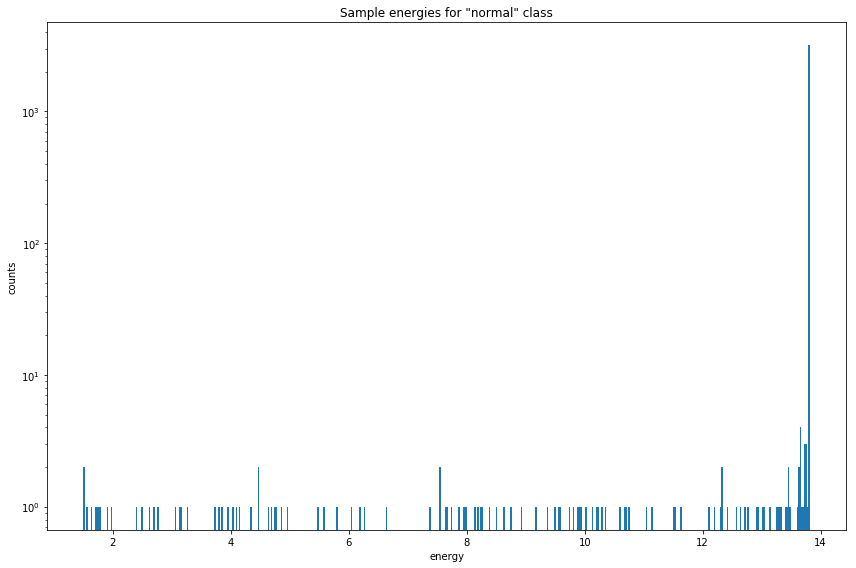

In [137]:
plt.hist(energies_normal, bins=hist_bins, log=True)

plt.title("Sample energies for \"normal\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-normalHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

- Energies from anomaly class

In [139]:

energies_anomaly = eval_net.predict(anomaly_data, batch_size=1, verbose=1)  

130/130 [==============================] - 0s 607us/step


In [140]:
energies_anomaly

array([13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 12.745616, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 

In [141]:
energies_anomaly.min()

12.745616

In [142]:
energies_anomaly.max()

13.815511

In [143]:
plt.hist?

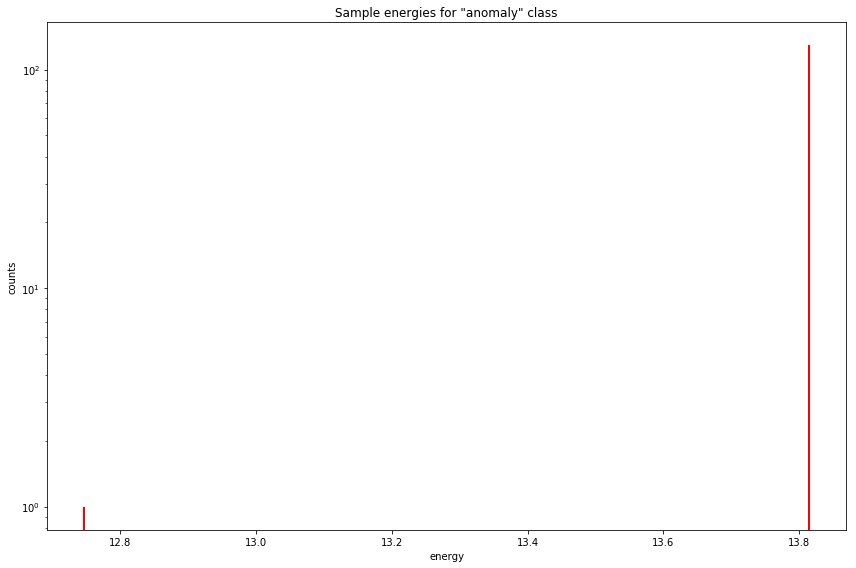

In [144]:
plt.hist(energies_anomaly, bins=hist_bins, color="red", log=True)

plt.title("Sample energies for \"anomaly\" class")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-anomalyHist_bins{}.png".format(hist_bins)
plt.savefig(filename)

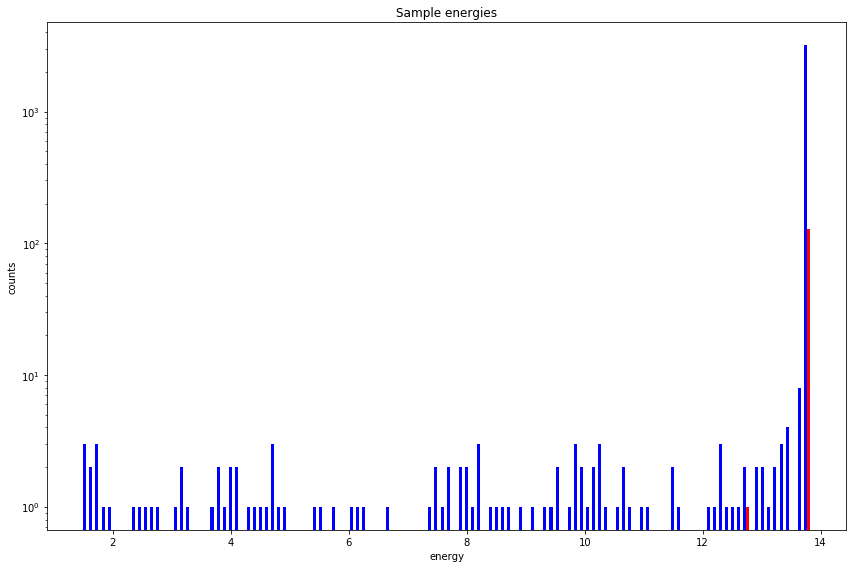

In [145]:
hist_bins = 120

plt.hist((energies_normal, energies_anomaly), 
         bins=hist_bins, 
         color=["blue", "red"], 
         histtype="bar", 
         label=["normal", "anomaly"], 
         rwidth=1.0,
         stacked=False,
         log=True)

plt.title("Sample energies")
plt.xlabel("energy")
plt.ylabel("counts")
plt.tight_layout()

filename = timestamp + "-allHist_bins{}.png".format(hist_bins)
plt.savefig(filename)


### Find the threshold for classifying as anomaly: "top %20 of highest energy"

In [146]:
energies_all = np.concatenate((energies_normal, energies_anomaly), axis=0)

In [147]:
energies_all.shape

(3427,)

- Sort calculated energies descending

In [148]:
sorted_energies = np.sort(energies_all)[::-1]

In [149]:
sorted_energies

array([13.815511 , 13.815511 , 13.815511 , ...,  1.5623878,  1.5037615,
        1.5012395], dtype=float32)

- Top %20 percent is the first %20 part of it

In [150]:
threshold_index = int(np.floor(len(sorted_energies) * 0.025))

In [151]:
sorted_energies[:threshold_index]

array([13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 13.815511, 13.815511,
       13.815511, 13.815511, 13.815511, 13.815511, 

In [152]:
threshold = sorted_energies[threshold_index]

- Below this threshold, samples are classified as normal

In [153]:
threshold

13.815511

### Calculate metrics

- "Anomaly class is positive" (from paper)

|                   | anomaly | normal |   |   |
|-------------------|---------|--------|---|---|
| predicted anomaly | TP      | FP     |   |   |
| predicted normal  | FN      | TN     |   |   |
|                   |         |        |   |   |

In [154]:
tp = len(energies_anomaly[energies_anomaly >= threshold])
fp = len(energies_normal[energies_normal > threshold])

tn = len(energies_normal[energies_normal <= threshold])
fn = len(energies_anomaly[energies_anomaly < threshold])

print(tp, fp, tn, fn)

129 0 3297 1


In [155]:
precision = tp / (tp + fp+0.00001)

In [156]:
precision

0.9999999224806262

In [157]:
recall = tp / (tp + fn)

In [158]:
recall

0.9923076923076923

In [159]:
f1 = 2*tp / (2*tp + fp + fn)

In [160]:
f1

0.9961389961389961